#### Group Project Members:

Laura Dennison, Daniel Zielinski, Jilong/Mark Lin, and Lingyue Lu

# Introduction to the Problem

We found a dataset off of Harvard's Dataverse called [Replication Data for: Using machine learning methods to predict physical activity types with Apple Watch and Fitbit data using indirect calorimetry as the criterion](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/ZS2Z2J). The dataset has 19 attributes and 1 class label, activity. The 19 attributes include raw data, feature engineered columns, and two columns of the row number. The goal of this analysis is to use the provided attributes and be able to predict the activity of a person who is wearing a Fitbit or Apple Watch. These activities are lying, sitting, self paced walking, running 3 METs, running 5 METs, and running 7 METs. The person who uploaded this dataset, Daniel Fuller, has already used this dataset to create a classification model of rotation forest models and determined the highest classification accuracies at 82.6% for Apple Watch and 89.3% for Fitbit. We want to see with the same dataset and some of our own analysis if we can match that classification accuracy or beat the accuracy.

Below is all the imports necessary for this project.

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import sklearn as sk
import time
import warnings
import random
warnings.simplefilter("ignore")

from sklearn.decomposition import PCA
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier,BaggingClassifier,ExtraTreesClassifier
from sklearn.ensemble import StackingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import  cross_val_predict, cross_val_score, GridSearchCV, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier


# Enable inline mode for matplotlib so that Jupyter displays graphs
%matplotlib inline

# Pre-Processing

In the data pre-processing stage, we will be exploring and cleaning the data before the analysis. This includes data exploration, data cleaning, and feature engineering.

## 1. Data Exploration

This is the step where we will understand our data's noise, outliers, missing data, incorrect data, and redundant data.

Read in the dataset and display the head to get an understanding of the data that will be worked with.

In [2]:
data = pd.read_csv("aw_fb_data.csv")
data.head()

,Unnamed: 0,X1,age,gender,height,weight,steps,heart_rate,calories,distance,entropy_heart,entropy_steps,resting_heart,corr_heart_steps,norm_heart,intensity_karvonen,sd_norm_heart,steps_times_distance,device,activity
0,1,1,20,1,168.0,65.4,10.771429,78.531302,0.344533,0.008327,6.221612,6.116349,59.0,1.000000,19.531302,0.138520,1.000000,0.089692,apple watch,Lying
1,2,2,20,1,168.0,65.4,11.475325,78.453390,3.287625,0.008896,6.221612,6.116349,59.0,1.000000,19.453390,0.137967,1.000000,0.102088,apple watch,Lying
2,3,3,20,1,168.0,65.4,12.179221,78.540825,9.484000,0.009466,6.221612,6.116349,59.0,1.000000,19.540825,0.138587,1.000000,0.115287,apple watch,Lying
3,4,4,20,1,168.0,65.4,12.883117,78.628260,10.154556,0.010035,6.221612,6.116349,59.0,1.000000,19.628260,0.139208,1.000000,0.129286,apple watch,Lying
4,5,5,20,1,168.0,65.4,13.587013,78.715695,10.825111,0.010605,6.221612,6.116349,59.0,0.982816,19.715695,0.139828,0.241567,0.144088,apple watch,Lying


Here we will display the missing values for all columns.

In [3]:
print("\nTotal num missing values:", data.isnull().sum())


Total num missing values: Unnamed: 0              0
X1                      0
age                     0
gender                  0
height                  0
weight                  0
steps                   0
heart_rate              0
calories                0
distance                0
entropy_heart           0
entropy_steps           0
resting_heart           0
corr_heart_steps        0
norm_heart              0
intensity_karvonen      0
sd_norm_heart           0
steps_times_distance    0
device                  0
activity                0
dtype: int64


## Univariate Analysis
Here we will analyze all the columns individually to determine any noise or outliers that could possibly by incorrect or duplicate data.

We will also analyze the label column, activity, to determine if the class labels are evenly distributed or not.

In [4]:
data.describe()

,Unnamed: 0,X1,age,gender,height,weight,steps,heart_rate,calories,distance,entropy_heart,entropy_steps,resting_heart,corr_heart_steps,norm_heart,intensity_karvonen,sd_norm_heart,steps_times_distance
count,6264.000000,6264.000000,6264.000000,6264.000000,6264.000000,6264.000000,6264.000000,6264.000000,6264.000000,6264.000000,6264.000000,6264.000000,6264.000000,6264.000000,6264.000000,6264.000000,6264.000000,6264.000000
mean,3132.500000,1771.144317,29.158525,0.476533,169.709052,69.614464,109.562268,86.142331,19.471823,13.832555,6.030314,5.739984,65.869938,0.306447,20.272393,0.155479,8.110854,590.035239
std,1808.405375,1097.988748,8.908978,0.499489,10.324698,13.451878,222.797908,28.648385,27.309765,45.941437,0.765574,1.256348,21.203017,0.775418,28.388116,0.210927,12.535080,4063.838530
min,1.000000,1.000000,18.000000,0.000000,143.000000,43.000000,1.000000,2.222222,0.056269,0.000440,0.000000,0.000000,3.000000,-1.000000,-76.000000,-2.714286,0.000000,0.000690
25%,1566.750000,789.750000,23.000000,0.000000,160.000000,60.000000,5.159534,75.598079,0.735875,0.019135,6.108524,5.909440,58.134333,-0.467303,1.148883,0.009819,0.264722,0.659260
50%,3132.500000,1720.000000,28.000000,0.000000,168.000000,68.000000,10.092029,77.267680,4.000000,0.181719,6.189825,6.157197,75.000000,0.665829,9.820254,0.079529,2.893503,13.368619
75%,4698.250000,2759.250000,33.000000,1.000000,180.000000,77.300000,105.847222,95.669118,20.500000,15.697188,6.247928,6.247928,76.138701,1.000000,27.077336,0.211868,9.679672,93.728562
max,6264.000000,3670.000000,56.000000,1.000000,191.000000,115.000000,1714.000000,194.333333,97.500000,335.000000,6.475733,6.475733,155.000000,1.000000,156.319444,1.297980,74.457929,51520.000000


Looking at all the data described above, the columns that should further be analyzed individually because of large differences between the maximum value and 75%, between the minimum value and 25%, and from the irregular mean are weight, steps, heart_rate, calories, distance, and resting_heart. The other columns such as entropy and correlation columns will be looked at in the feature engineering section to determine the columns calculations that then became a column in the dataset.

We will also look at the categorical columns to see the balance or imbalance of the dataset for that attribute.

### WEIGHT

WEIGHT:
count    6264.000000
mean       69.614464
std        13.451878
min        43.000000
25%        60.000000
50%        68.000000
75%        77.300000
max       115.000000
Name: weight, dtype: float64
range: 72.0
median: 68.0


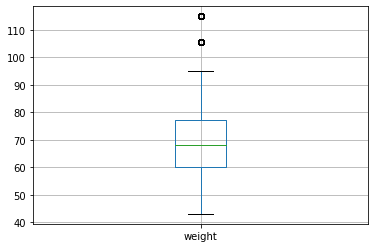

In [5]:
# weight column is a numeric value
data['weight'] = pd.to_numeric(data['weight'])
print("WEIGHT:")
print(data['weight'].describe())
print("range:", data['weight'].max() - data['weight'].min())
print("median:", data['weight'].median())
data.boxplot(['weight'])

#### Weight Analysis
The minimum weight is 43kg (94lbs), and the maximum weight is 115kg (253lbs). While there are a few outliers, the weights are within reason, so the outliers should remain. The data only needs to be standardized.

### STEPS

STEPS:
count    6264.000000
mean      109.562268
std       222.797908
min         1.000000
25%         5.159534
50%        10.092029
75%       105.847222
max      1714.000000
Name: steps, dtype: float64
range: 1713.0
median: 10.09202887

Value Counts:
1.000000       339
10.771429       42
1.157895        30
10.631579       30
4.000000        28
              ... 
6.963636         1
13.560000        1
403.739130       1
1281.000000      1
59.532468        1
Name: steps, Length: 3918, dtype: int64


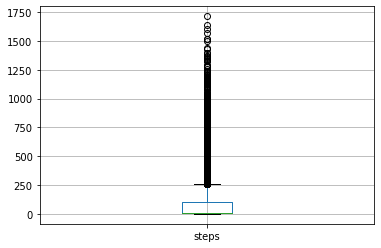

In [6]:
# steps column is a numeric value
data['steps'] = pd.to_numeric(data['steps'])
print("STEPS:")
print(data['steps'].describe())
print("range:", data['steps'].max() - data['steps'].min())
print("median:", data['steps'].median())
print()
print('Value Counts:\n', data['steps'].value_counts(), sep='')
data.boxplot(['steps'])

#### Steps Analysis:
There are a lot of outliers for steps, but, the outliers are gradual and do not look like a mistake as people take more than 250 steps.

### HEART RATE

HEART RATE:
count    6264.000000
mean       86.142331
std        28.648385
min         2.222222
25%        75.598079
50%        77.267680
75%        95.669118
max       194.333333
Name: heart_rate, dtype: float64
range: 192.11111107800002
median: 77.26768008


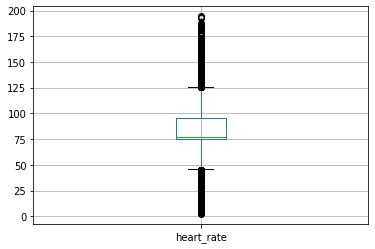

In [7]:
# heart rate column is a numeric value
data['heart_rate'] = pd.to_numeric(data['heart_rate'])
print("HEART RATE:")
print(data['heart_rate'].describe())
print("range:", data['heart_rate'].max() - data['heart_rate'].min())
print("median:", data['heart_rate'].median())
data.boxplot(['heart_rate'])

#### Heart Rate Analysis:
The lowest heart rate calculated by a living person was 28 beats per minute. Therefore, these really low numbers are not possible on people and are incorrect. Those low numbers should use the average heart rate by age.

The highest heart rate is 194 beats per minute. You can calculate your maximum heart rate by subtracting your age from 220. 

This data correction will be difficult in assuring the data is correct since the values range significantly and incorrectly for a living person.

### CALORIES

CALORIES:
count    6264.000000
mean       19.471823
std        27.309765
min         0.056269
25%         0.735875
50%         4.000000
75%        20.500000
max        97.500000
Name: calories, dtype: float64
range: 97.443730769
median: 4.0


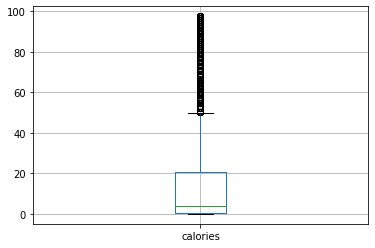

In [8]:
# calories column is a numeric value
data['calories'] = pd.to_numeric(data['calories'])
print("CALORIES:")
print(data['calories'].describe())
print("range:", data['calories'].max() - data['calories'].min())
print("median:", data['calories'].median())
data.boxplot(['calories'])

#### Calories Analysis:
This seems to be the amount of calories burned in a time frame since the numbers are from 0 to 97. Most people seem to not be burning that many calories, so the outliers are primarily in the high range. However, the outliers are continous from around 50 to 97, which means the outliers are most likely not noise, but should be taken into consideration.

### DISTANCE

DISTANCE:
count    6264.000000
mean       13.832555
std        45.941437
min         0.000440
25%         0.019135
50%         0.181719
75%        15.697188
max       335.000000
Name: distance, dtype: float64
range: 334.99956
median: 0.1817185


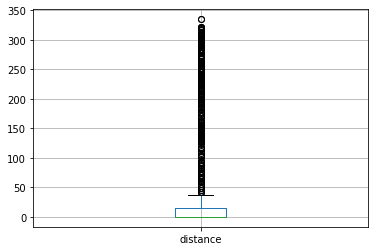

In [9]:
# distance column is a numeric value
data['distance'] = pd.to_numeric(data['distance'])
print("DISTANCE:")
print(data['distance'].describe())
print("range:", data['distance'].max() - data['distance'].min())
print("median:", data['distance'].median())
data.boxplot(['distance'])

#### Distance Analysis:
Distance, similar to Calories, is generally very low with a lot of outliers greater than most of the values.

### RESTING HEART RATE

RESTING HEART RATE:
count    6264.000000
mean       65.869938
std        21.203017
min         3.000000
25%        58.134333
50%        75.000000
75%        76.138701
max       155.000000
Name: resting_heart, dtype: float64
range: 152.0
median: 75.0


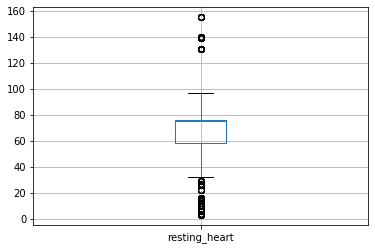

In [10]:
# resting_heart column is a numeric value
data['resting_heart'] = pd.to_numeric(data['resting_heart'])
print("RESTING HEART RATE:")
print(data['resting_heart'].describe())
print("range:", data['resting_heart'].max() - data['resting_heart'].min())
print("median:", data['resting_heart'].median())
data.boxplot(['resting_heart'])

#### Resting Heart Rate Analysis:
Just like heart rate, the resting heart rate has values below 28, which is the minimum beats per minute of a living person. Those values less than 28 will need to be binned or replaced with the median values.

### DEVICE

DEVICE:
device
apple watch    3656
fitbit         2608
dtype: int64


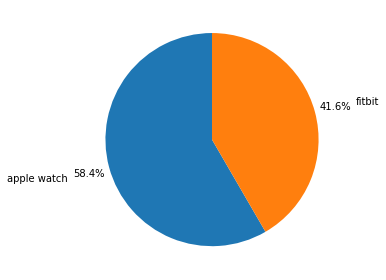

In [11]:
# device column is a categorical value
print("DEVICE:")
groups = data.groupby('device')
print(groups.size())
pie_edu = groups.size().plot(kind='pie', autopct='%1.1f%%', pctdistance=1.2, labeldistance=1.4, startangle=90)
pie_edu.set_ylabel('')
pie_edu.set_xlabel('')
plt.tight_layout()
plt.show()

#### Device Analysis:
There are more apple watches than fitbits in the dataset. This difference is not so significant to the results of this problem, which is to determine the activity. So, no data cleaning should be necessary for this attribute.

### ACTIVITY

ACTIVITY:
activity
Lying             1379
Running 3 METs     950
Running 5 METs    1002
Running 7 METs    1114
Self Pace walk     889
Sitting            930
dtype: int64


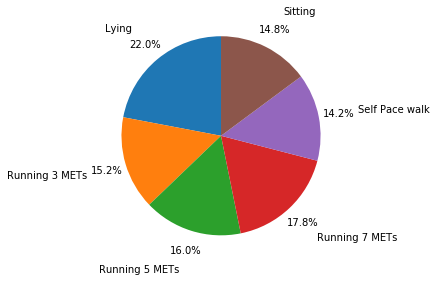

In [12]:
# activity column is a categorical value of the label
print("ACTIVITY:")
groups = data.groupby('activity')
print(groups.size())
pie_edu = groups.size().plot(kind='pie', autopct='%1.1f%%', pctdistance=1.2, labeldistance=1.4, startangle=90)
pie_edu.set_ylabel('')
pie_edu.set_xlabel('')
plt.tight_layout()
plt.show()

#### Activity Analysis:
All the activities are fairly uniform ranging from being 14.2% of the data to 22% of the data. For a multi-class dataset of 6 different classes, this distribution is reasonable enough to not need any data cleaning to even out the classes with oversampling, undersampling, or SMOTE.

### Univariate Analysis Summary:
Out of the features analyzed, only one numeric feature did not have any outliers, height. The rest of the numeric features had either a few outliers, age and weight, or had a lot of outliers, steps, heart rate, calories, distance, and resting heart rate.

## Multivariate Analysis
In this next section of the data exploration, we will be taking attributes and anlyzing them together to find outliers or noise.

### GENDER, HEIGHT, WEIGHT

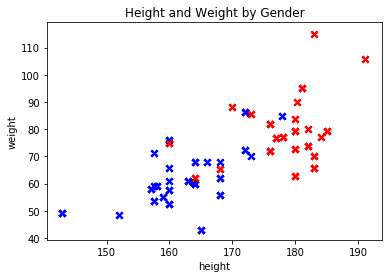

In [13]:
females = data[data['gender'] == 0]
males = data[data['gender'] == 1]

# plot females in blue
plt.scatter(females['height'], 
           females['weight'], 
           c='blue', marker = 'x')

# plot males in red
plt.scatter(males['height'], 
           males['weight'], 
           c='red', marker = 'x')

plt.xlabel('height')
plt.ylabel('weight')
plt.title("Height and Weight by Gender")
plt.show()

#### Gender, Height, and Weight Analysis:
This scatterplot shows a generalized look at how the various the people are based on gender, height, and weight. Overall, the height and weight are positively correlated with females generally less than males in weight and height. This analysis demonstrates a fairly normal distribution of people for this project.

### STEPS, DISTANCE

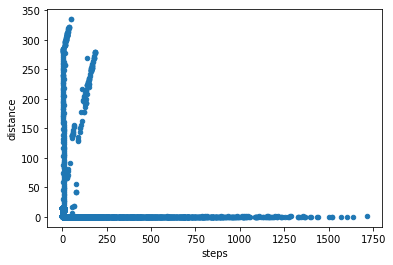

In [14]:
data.plot.scatter('steps', 'distance')

#### Steps and Distance Analysis:
This here demonstrates that any distance made does not equate to number of steps. Those with more distance have less steps. If the data is correct, this could only mean that people are walking in place, or the steps are of the day and the distance is of that time.

With data cleaning of the steps and distance, hopefully this comparison becomes more distinctive.

### CALORIES, HEART RATE

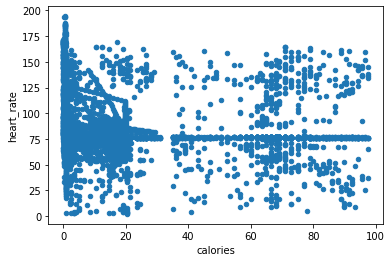

In [15]:
data.plot.scatter('calories', 'heart_rate')

#### Calories and Heart Rate Analysis:
There does not seem to be a strong correlation between heart rate and amount of calories burned.

### ACTIVITY ANALYSIS

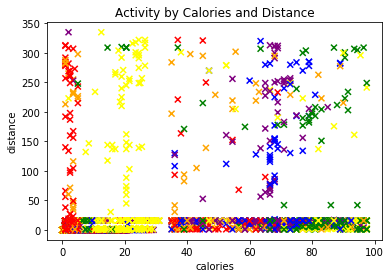

In [16]:
activities = {'Lying':'red', 'Running 3 METs':'blue', 'Running 5 METs':'green', 'Running 7 METs':'yellow',
             'Self Pace walk':'purple', 'Sitting':'orange'}
plt.scatter(data['calories'], 
           data['distance'], 
           c=data['activity'].apply(lambda x: activities[x]),
           marker = 'x')
plt.xlabel('calories')
plt.ylabel('distance')
plt.title("Activity by Calories and Distance")
plt.show()

#### Calories and Distance Analysis:
There seems to be a high correlation between calories and the activity. Calories between 10 and 30 seem to equate more Running 7 METs, and calories close to zero equate to Lying. There are a lot of data points that blend in at the bottom of the scatter plot where distance is close to zero, which could still mean any activity.

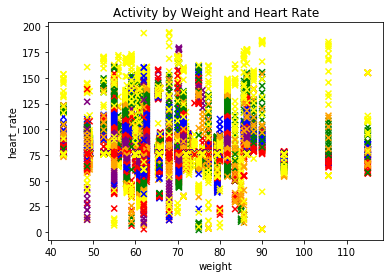

In [17]:
activities = {'Lying':'red', 'Running 3 METs':'blue', 'Running 5 METs':'green', 'Running 7 METs':'yellow',
             'Self Pace walk':'purple', 'Sitting':'orange'}
plt.scatter(data['weight'], 
           data['heart_rate'], 
           c=data['activity'].apply(lambda x: activities[x]),
           marker = 'x')
plt.xlabel('weight')
plt.ylabel('heart_rate')
plt.title("Activity by Weight and Heart Rate")
plt.show()

#### Weight and Heart Rate Analysis:
The only activity that stands out is Running 7 METs, which seems to have the highest heart_rates no matter the weight.

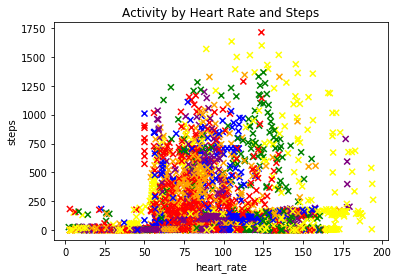

In [18]:
activities = {'Lying':'red', 'Running 3 METs':'blue', 'Running 5 METs':'green', 'Running 7 METs':'yellow',
             'Self Pace walk':'purple', 'Sitting':'orange'}
plt.scatter(data['heart_rate'], 
           data['steps'], 
           c=data['activity'].apply(lambda x: activities[x]),
           marker = 'x')
plt.xlabel('heart_rate')
plt.ylabel('steps')
plt.title("Activity by Heart Rate and Steps")
plt.show()

#### Heart Rate and Steps Analysis:
There is a correlation between high heart rates, more steps, and Running 7 METs. The next highest heart rate with steps is Running 5 METs. After that, with so many activities, the colors start to blend with lying, sitting, self pace walking, and running 3 METs.

### Overall Data Exploration Analysis:
This dataset is has no missing data. However, there is some data that seems to be incorrect such as the heart rates below 28 beats per minute. The incorrect data will need to be resolved in the next section, data cleaning. The heart rate also seems to have a higher correlation with the activity involving Running 7 METs.

## 2. Data Cleaning
This is where we will take the explored data and correct the records in the data set depending on that anlysis. Some features will need to be cleaned in a pipeline since they will be standardized and only the training set is allowed to be standardized. Therefore, in this section, we will only clean up heart rate and resting heart rate since some of those data points are below the minimum threshold.

### HEART RATE
We need to correct any heart rates below 28 beats per minute to be the median value. Any heart rate below 28 beats per minute is incorrect since that is not possible. We will also make sure all high values are correct according to the rules that the maximum heart rate is 220 minus your age.

count    6264.000000
mean       87.341461
std        26.859190
min        28.069072
25%        75.737305
50%        77.267680
75%        95.669118
max       194.333333
Name: heart_rate, dtype: float64


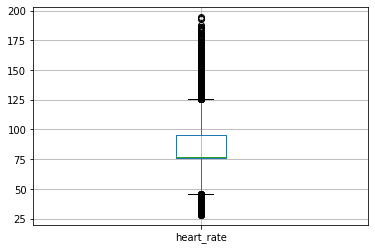

In [19]:
# First, we will correct the low heart rates
med = data['heart_rate'].median()
data['heart_rate'] = data['heart_rate'].apply(lambda x : x if x > 28.00 else med)

# Second, we will go through the high heart rates
data['heart_rate'].mask(220 - data['age'] < data['heart_rate'], 220 - data['age'], inplace=True)

print(data['heart_rate'].describe())
data.boxplot(['heart_rate'])

### RESTING HEART RATE
Just like the heart rate column, we need to change any heart rate below 28 to be the median value.

count    6264.000000
mean       70.797189
std        14.465997
min        29.000000
25%        64.270409
50%        75.000000
75%        76.138701
max       155.000000
Name: resting_heart, dtype: float64


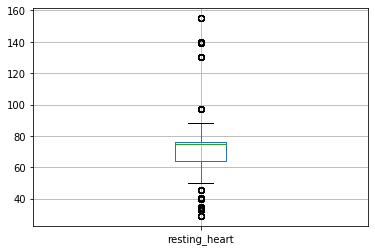

In [20]:
med = data['resting_heart'].median()

data['resting_heart'] = data['resting_heart'].apply(lambda x : x if x > 28.00 else med)
data.boxplot(['resting_heart'])
print(data['resting_heart'].describe())

### INTENSITY KARVONEN
The formula for karvonen uses the resting heart rate and the maximum heart rate to determine the [target training heart rate](https://www.physiotherapy-treatment.com/karvonen-formula.html). This formula is calculated to determine the target heart rate during workouts. Since the heart rates have been cleaned by replacing any values below 28 with the median, we will need to recalculate the intensity_karvonen column. We will also rename the intensity_karvonen column to be just karvonen for simplicity.

count    6264.000000
mean      142.823761
std         8.169521
min       111.429687
25%       139.343862
50%       143.069135
75%       147.868719
max       174.200000
Name: karvonen, dtype: float64


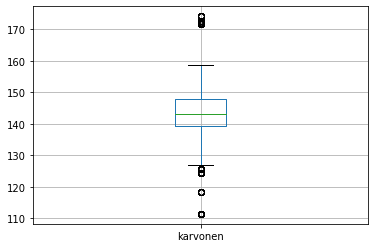

In [21]:
data['intensity_karvonen'].mask(
    data['resting_heart']+(0.6*((220 - data['age'])-data['resting_heart'])) != data['intensity_karvonen'], 
         data['resting_heart']+(0.6*((220 - data['age'])-data['resting_heart'])), inplace=True)

data = data.rename(columns={'intensity_karvonen' : 'karvonen'})

data.boxplot(['karvonen'])
print(data['karvonen'].describe())

### Data Cleaning Analysis:
We have cleaned the heart rate columns to have every value above 28 beats per minute to which we then re-calculated the intensity karvonen column using the new resting heart rates. 

In the feature engineering section, we will have to adjust the other columns to match the cleaned dataset or be removed from the dataset completely. The rest of the columns will be standardized in a pipeline during the method classifiers creation.

Below is the dataset's numeric descriptions after data cleaning.

In [22]:
data.describe()

,Unnamed: 0,X1,age,gender,height,weight,steps,heart_rate,calories,distance,entropy_heart,entropy_steps,resting_heart,corr_heart_steps,norm_heart,karvonen,sd_norm_heart,steps_times_distance
count,6264.000000,6264.000000,6264.000000,6264.000000,6264.000000,6264.000000,6264.000000,6264.000000,6264.000000,6264.000000,6264.000000,6264.000000,6264.000000,6264.000000,6264.000000,6264.000000,6264.000000,6264.000000
mean,3132.500000,1771.144317,29.158525,0.476533,169.709052,69.614464,109.562268,87.341461,19.471823,13.832555,6.030314,5.739984,70.797189,0.306447,20.272393,142.823761,8.110854,590.035239
std,1808.405375,1097.988748,8.908978,0.499489,10.324698,13.451878,222.797908,26.859190,27.309765,45.941437,0.765574,1.256348,14.465997,0.775418,28.388116,8.169521,12.535080,4063.838530
min,1.000000,1.000000,18.000000,0.000000,143.000000,43.000000,1.000000,28.069072,0.056269,0.000440,0.000000,0.000000,29.000000,-1.000000,-76.000000,111.429687,0.000000,0.000690
25%,1566.750000,789.750000,23.000000,0.000000,160.000000,60.000000,5.159534,75.737305,0.735875,0.019135,6.108524,5.909440,64.270409,-0.467303,1.148883,139.343862,0.264722,0.659260
50%,3132.500000,1720.000000,28.000000,0.000000,168.000000,68.000000,10.092029,77.267680,4.000000,0.181719,6.189825,6.157197,75.000000,0.665829,9.820254,143.069135,2.893503,13.368619
75%,4698.250000,2759.250000,33.000000,1.000000,180.000000,77.300000,105.847222,95.669118,20.500000,15.697188,6.247928,6.247928,76.138701,1.000000,27.077336,147.868719,9.679672,93.728562
max,6264.000000,3670.000000,56.000000,1.000000,191.000000,115.000000,1714.000000,194.333333,97.500000,335.000000,6.475733,6.475733,155.000000,1.000000,156.319444,174.200000,74.457929,51520.000000


## 3. Feature Engineering
This is where we will use dimensionality reduction and feature selection. The dataset already came with feature engineered columns such as entropy_heart, entropy_steps, corr_heart_steps, norm_heart, intensity_karvonen, sd_norm_heart, and steps_times_distance. We have already adjusted the intensity_karvonen column to be the karvonen formula of the optimal heart rate during cardio excersise, but the other columns will have to be removed since entropy, normalization, and standardization are determined based on the other columns and would then cause data leakage.

### DELETING COLUMNS
We will remove columns entropy_heart, entropy_steps, corr_heart_steps, norm_heart, sd_norm_heart, and steps_times_distance since these features are dependent upon the dataset's overall relationship to one another and any analysis of those features would be data leakage. We will also drop the unnamed column and X1 column to only look at the attributes and label (activity) and not the row labels.

In [23]:
data = data.drop(['Unnamed: 0', 'X1', 'entropy_heart', 'entropy_steps', 'corr_heart_steps', 'norm_heart', 
           'sd_norm_heart', 'steps_times_distance'], axis=1)

data.head()

,age,gender,height,weight,steps,heart_rate,calories,distance,resting_heart,karvonen,device,activity
0,20,1,168.0,65.4,10.771429,78.531302,0.344533,0.008327,59.0,143.6,apple watch,Lying
1,20,1,168.0,65.4,11.475325,78.453390,3.287625,0.008896,59.0,143.6,apple watch,Lying
2,20,1,168.0,65.4,12.179221,78.540825,9.484000,0.009466,59.0,143.6,apple watch,Lying
3,20,1,168.0,65.4,12.883117,78.628260,10.154556,0.010035,59.0,143.6,apple watch,Lying
4,20,1,168.0,65.4,13.587013,78.715695,10.825111,0.010605,59.0,143.6,apple watch,Lying


### FEATURE CREATION
With the removal of transformed columns, we will create new columns. One of these columns will be the difference between karvonen and heart_rate to determine if that person during that time is reaching their optimal cardio heart rate. Any positive number means that the person's heart rate is not at optimal cardio level, while any negative number means the heart rate is above cardio level.

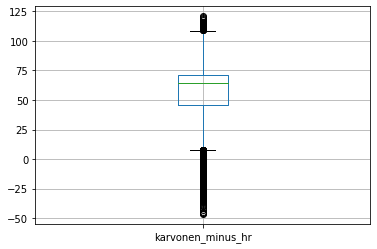

In [24]:
# create karvonen_minus_hr. anything positive means less than optimal heart rate for cardio workouts
data['karvonen_minus_hr'] = data.apply(lambda row: row.karvonen - row.heart_rate, axis = 1) 

data.boxplot(['karvonen_minus_hr'])

#### Decompose Categorical Attribute
Here we will seperate the device column to have seperate apple watch and fitbit columns. We will also seperate gender to be male (1) and female (0).

In [25]:
# split device column to be apple watch and fitbit
data['app_watch'] = data['device'].apply(lambda x : 1 if x == 'apple watch' else 0)
data['fitbit'] = data['device'].apply(lambda x : 1 if x == 'fitbit' else 0)

# split gender column to be male and female
data['female'] = data['gender'].apply(lambda x : 1 if x == 0 else 0)
data['male'] = data['gender'].apply(lambda x : 0 if x == 0 else 1)

### REORGANIZE COLUMNS
Now that all the features have been created, we will organize the columns logically by relationship with one another and have the label column, activity, as the last column.

In [26]:
# Rearrange the columns. activity is the label column
data = data[['age', 'female', 'male', 'height', 'weight', 'heart_rate', 'resting_heart', 'karvonen', 
             'karvonen_minus_hr', 'calories', 'steps', 'distance', 'app_watch', 'fitbit', 'activity']]

data.head(20)

,age,female,male,height,weight,heart_rate,resting_heart,karvonen,karvonen_minus_hr,calories,steps,distance,app_watch,fitbit,activity
0,20,0,1,168.0,65.4,78.531302,59.0,143.6,65.068698,0.344533,10.771429,0.008327,1,0,Lying
1,20,0,1,168.0,65.4,78.453390,59.0,143.6,65.146610,3.287625,11.475325,0.008896,1,0,Lying
2,20,0,1,168.0,65.4,78.540825,59.0,143.6,65.059175,9.484000,12.179221,0.009466,1,0,Lying
3,20,0,1,168.0,65.4,78.628260,59.0,143.6,64.971740,10.154556,12.883117,0.010035,1,0,Lying
4,20,0,1,168.0,65.4,78.715695,59.0,143.6,64.884305,10.825111,13.587013,0.010605,1,0,Lying
5,20,0,1,168.0,65.4,78.803129,59.0,143.6,64.796871,11.495667,14.290909,0.011174,1,0,Sitting
6,20,0,1,168.0,65.4,78.890564,59.0,143.6,64.709436,12.166222,14.994805,0.011744,1,0,Sitting
7,20,0,1,168.0,65.4,78.977999,59.0,143.6,64.622001,12.836778,15.698701,0.012313,1,0,Sitting
8,20,0,1,168.0,65.4,79.065434,59.0,143.6,64.534566,13.507333,16.402597,0.012883,1,0,Sitting
9,20,0,1,168.0,65.4,79.152869,59.0,143.6,64.447131,14.177889,17.106494,0.013452,1,0,Sitting


## PRE-PROCESSING ANALYSIS
After going through the pre-processing steps of data exploration, data cleaning, and feature engineering, we ended up with 14 attributes after starting with 19 attributes. The dataset did not have any missing data, however, the heart rate data had some incorrect values from unlikely heart rate paces below 28 beats per minute, which is impossible for a living person. Those data records were corrected to the median value. Overall, the dataset is easy to read with descriptive titles for all attributes and enough records to possibly make a reasonable classification model.

If the creator of this dataset created a classification model based on the features previously engineered in the dataset, I wonder if the normalized features would have caused data leakage and for his analysis to have an inaccurately high generalization error.

In the next sections, we will be building classification models from this analyzed data using all the types of models learned in class. From there, we will then build ensemble methods to ultimately determine the best classification model. This is where we will compare our model's success to the success of the model built by Daniel Fuller, the data scientist who originally created the dataset.

# Building the Models

From a real world perspective, we believe that Apple Watches and Fitbit devices might report health data with different levels of accuracy. Since Fitbit is a fitness-oriented device, we suspect it might report diagnostic data more accurately. To account for this, we will build models and assess accuracy for Apple Watch and Fitbit data separately.

We will build several types of classification models - decision trees, k nearest neighbors, naive bayes, support vector machines, and artificial neural networks. For each classifier type, we will find the best models for both wearable devices, and then we will compare all of the results at the end. Eventually, the best models from this section will be compared to the best ensemble models.

Since our data has very balanced classes, we think it is suitable to use generalization accuracy rather than F-measure to compare models. 5 fold cross validations will be utilized to minimize computation time.

## Preparing For Model Building
Before we begin building models, we must split the data based on wearable device, and we must separate each of those subsets into features and labels. We will use dictionaries to keep track of the generalization accuracy for each model. That will allow us to easily compare and select the best models at the end.

In [27]:
# set number of folds to use
NUM_FOLDS = 5

# set number of cpu cores to use (half of available cores)
NUM_CORES = os.cpu_count() // 2

# split data into Apple Watch and Fitbit
aw_data = data[data.app_watch == 1]
fb_data = data[data.fitbit == 1]

# drop the device identifier columns from the data
aw_data.drop(['app_watch', 'fitbit'], axis=1, inplace=True)
fb_data.drop(['app_watch', 'fitbit'], axis=1, inplace=True)

# split aw data into features and labels
Y_aw = aw_data['activity']
X_aw = aw_data.drop('activity', axis=1)

# split fb data into features and labels
Y_fb = fb_data['activity']
X_fb = fb_data.drop('activity', axis=1)

# create dictionaries to keep track of models' generalization accuracies
aw_accuracies = dict()
fb_accuracies = dict()

## 1. Decision Trees
Now we will build the best decision tree model for each wearable.

Since magnitude is unimportant to decision trees, scaling is not necessary. In addition, decision trees are good at determining the importance of features, so any sort of dimensionality reduction, like PCA, is unnecessary.

In our hyperparameter tuning, we will try both entropy and gini for the split measurement. We will try various, modest numbers for max_depth, min_samples_split, and min_samples_leaf to prevent the tree from overfitting to the data. Though we have a decent number of records, we want to avoid overly specific leaves with few data points since such a tree won't generalize well.

In [28]:
# define tree parameters to try
tree_params = {'criterion': ['entropy', 'gini'],
              'max_depth': list(range(5, 21, 5)),
              'min_samples_leaf': list(range(5, 21, 5)),
              'max_features': list(range(4,13))}

### APPLE WATCH
#### Generalization Accuracy

In [29]:
# create grid search with decision tree
aw_tree_grid = GridSearchCV(DecisionTreeClassifier(), tree_params, cv=NUM_FOLDS, scoring='accuracy', n_jobs=NUM_CORES)

# get the cross val scores
aw_tree_scores = cross_val_score(aw_tree_grid, X_aw, Y_aw, cv=NUM_FOLDS, n_jobs=NUM_CORES);

In [30]:
# get and print the generalization accuracy
aw_tree_acc = aw_tree_scores.mean()
print(f'Generalization Accuracy of Decision Tree (Apple Watch):\n{aw_tree_acc:.6f}')

# add accuracy to dictionary
aw_accuracies['decision_tree'] = aw_tree_acc

Generalization Accuracy of Decision Tree (Apple Watch):
0.290229


#### Best Hyperparameters

In [31]:
# find the best parameters based on our entire dataset
aw_tree_grid.fit(X_aw, Y_aw);

In [32]:
# print best hyperparameters
print(f'Best Decision Tree (Apple Watch) Hyperparameters for our Dataset:\n{aw_tree_grid.best_params_}')

Best Decision Tree (Apple Watch) Hyperparameters for our Dataset:
{'criterion': 'gini', 'max_depth': 15, 'max_features': 7, 'min_samples_leaf': 15}


### FITBIT
#### Generalization Accuracy

In [33]:
# create grid search with decision tree
fb_tree_grid = GridSearchCV(DecisionTreeClassifier(), tree_params, cv=NUM_FOLDS, scoring='accuracy', n_jobs=NUM_CORES)

# get the cross val scores
fb_tree_scores = cross_val_score(fb_tree_grid, X_fb, Y_fb, cv=NUM_FOLDS, n_jobs=NUM_CORES);

In [34]:
# get and print the generalization accuracy
fb_tree_acc = fb_tree_scores.mean()
print(f'Generalization Accuracy of Decision Tree (Fitbit):\n{fb_tree_acc:.6f}')

# add accuracy to dictionary
fb_accuracies['decision_tree'] = fb_tree_acc

Generalization Accuracy of Decision Tree (Fitbit):
0.738811


#### Best Hyperparameters

In [35]:
# find the best parameters based on our entire dataset
fb_tree_grid.fit(X_fb, Y_fb);

In [36]:
# print best hyperparameters
print(f'Best Decision Tree (Fitbit) Hyperparameters for our Dataset:\n{fb_tree_grid.best_params_}')

Best Decision Tree (Fitbit) Hyperparameters for our Dataset:
{'criterion': 'entropy', 'max_depth': 15, 'max_features': 12, 'min_samples_leaf': 15}


There is a significant disparity between generalization accuracy for the Apple Watch and Fitbit decision trees. We will keep an eye out for this pattern from here.

## 2. K Nearest Neighbor
Now we will build the best k-nearest neighbor model for each wearable.

Since k-nearest neighbor calculates euclidean distance, scaling is vital and will be a part of the pipeline. Additionally, since this type of model is highly susceptible to the curse of dimensionality, we will add PCA dimensionality reduction to the pipeline.

Since it is one of the more straightforward models, we will only tune one model hyperparameter, k, the number of neighbors to use in classification. We will also search for the best number of components for the PCA.

In [37]:
# define knn parameters to try
knn_params = {'knn__n_neighbors': list(range(1, 41)),
             'pca__n_components': list(range(1, 13))}

### APPLE WATCH
#### Generalization Accuracy

In [38]:
# create pipeline: scaling => pca => knn
aw_knn_pipe = Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA()), ('knn', KNeighborsClassifier())])

# create grid search
aw_knn_grid = GridSearchCV(aw_knn_pipe, knn_params, cv=NUM_FOLDS, n_jobs=NUM_CORES)

# get the cross val scores
aw_knn_scores = cross_val_score(aw_knn_grid, X_aw, Y_aw, cv=NUM_FOLDS, n_jobs=NUM_CORES);

In [39]:
# get and print generalization accuracy
aw_knn_acc = aw_knn_scores.mean()
print(f'Generalization Accuracy of K-Nearest Neighbor (Apple Watch):\n{aw_knn_acc:.6f}')

# add accuracy to dictionary
aw_accuracies['knn'] = aw_knn_acc

Generalization Accuracy of K-Nearest Neighbor (Apple Watch):
0.266148


#### Best Hyperparameters

In [40]:
# find best parameters based on entire dataset
aw_knn_grid.fit(X_aw, Y_aw);

In [41]:
# print best hyperparameters
print(f'Best KNN (Apple Watch) Hyperparameters for our Dataset:\n{aw_knn_grid.best_params_}')

Best KNN (Apple Watch) Hyperparameters for our Dataset:
{'knn__n_neighbors': 25, 'pca__n_components': 6}


### FITBIT
#### Generalization Accuracy

In [42]:
# create pipeline: scaling => pca => knn
fb_knn_pipe = Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA()), ('knn', KNeighborsClassifier())])

# create grid search
fb_knn_grid = GridSearchCV(fb_knn_pipe, knn_params, cv=NUM_FOLDS, n_jobs=NUM_CORES)

# get the cross val scores
fb_knn_scores = cross_val_score(fb_knn_grid, X_fb, Y_fb, cv=NUM_FOLDS, n_jobs=NUM_CORES);

In [43]:
# get and print generalization accuracy
fb_knn_acc = fb_knn_scores.mean()
print(f'Generalization Accuracy of K-Nearest Neighbor (Fitbit):\n{fb_knn_acc:.6f}')

# add accuracy to dictionary
fb_accuracies['knn'] = fb_knn_acc

Generalization Accuracy of K-Nearest Neighbor (Fitbit):
0.375748


#### Best Hyperparameters

In [44]:
# find best parameters based on entire dataset
fb_knn_grid.fit(X_fb, Y_fb);

In [45]:
# print best hyperparameters
print(f'Best KNN (Fitbit) Hyperparameters for our Dataset:\n{fb_knn_grid.best_params_}')

Best KNN (Fitbit) Hyperparameters for our Dataset:
{'knn__n_neighbors': 17, 'pca__n_components': 5}


Similar to the decision tree situation, we see a higher generalization accuracy for the KNN model that used the Fitbit data.

## 3. Naive Bayes
Here we will build the best naive bayes model for each wearable.

Since this model utilizes probability, the magnitudes of the features is irrelevant. Therefore, scaling is unnecessary and won't be performed here. Since Naive Bayes assumes that features are independent of each other, it would be helpful to utilize PCA dimensionality reduction. Then the features will be as uncorrelated as possible.

As one of the simplest models we will be trying, there are no hyperparameters to tune for the model. We will be tuning the number of components to keep for the PCA.

In [46]:
# define nb parameters to try
nb_params = {'pca__n_components': list(range(1, 13))}

### APPLE WATCH
#### Generalization Accuracy

In [47]:
# create pipeline: pca => nb
aw_nb_pipe = Pipeline(steps=[('pca', PCA()), ('nb', GaussianNB())])

# create grid search
aw_nb_grid = GridSearchCV(aw_nb_pipe, nb_params, cv=NUM_FOLDS, n_jobs=NUM_CORES)

# get the cross val scores
aw_nb_scores = cross_val_score(aw_nb_grid, X_aw, Y_aw, cv=NUM_FOLDS, n_jobs=NUM_CORES);

In [48]:
# get and print generalization accuracy
aw_nb_acc = aw_nb_scores.mean()
print(f'Generalization Accuracy of Naive Bayes (Apple Watch):\n{aw_nb_acc:.6f}')

# add accuracy to dictionary
aw_accuracies['naive_bayes'] = aw_nb_acc

Generalization Accuracy of Naive Bayes (Apple Watch):
0.278459


#### Best Hyperparameters

In [49]:
# find best parameters based on entire dataset
aw_nb_grid.fit(X_aw, Y_aw);

In [50]:
# print best hyperparameters
print(f'Best Naive Bayes (Apple Watch) Hyperparameters for our Dataset:\n{aw_nb_grid.best_params_}')

Best Naive Bayes (Apple Watch) Hyperparameters for our Dataset:
{'pca__n_components': 2}


### FITBIT
#### Generalization Accuracy

In [51]:
# create pipeline: pca => nb
fb_nb_pipe = Pipeline(steps=[('pca', PCA()), ('nb', GaussianNB())])

# create grid search
fb_nb_grid = GridSearchCV(fb_nb_pipe, nb_params, cv=NUM_FOLDS, n_jobs=NUM_CORES)

# get the cross val scores
fb_nb_scores = cross_val_score(fb_nb_grid, X_fb, Y_fb, cv=NUM_FOLDS, n_jobs=NUM_CORES);

In [52]:
# get and print generalization accuracy
fb_nb_acc = fb_nb_scores.mean()
print(f'Generalization Accuracy of Naive Bayes (Fitbit):\n{fb_nb_acc:.6f}')

# add accuracy to dictionary
fb_accuracies['naive_bayes'] = fb_nb_acc

Generalization Accuracy of Naive Bayes (Fitbit):
0.363485


#### Best Hyperparameters

In [53]:
# find best parameters based on entire dataset
fb_nb_grid.fit(X_fb, Y_fb);

In [54]:
# print best hyperparameters
print(f'Best Naive Bayes (Fitbit) Hyperparameters for our Dataset:\n{fb_nb_grid.best_params_}')

Best Naive Bayes (Fitbit) Hyperparameters for our Dataset:
{'pca__n_components': 3}


Like the previous 2 models, we see higher accuracy with the Fitbit data, though the difference is a bit smaller here.

## 4. Support Vector Machines
Now we will build the best support vector classifier for each wearable device.

Since SVMs utilize distance in the creations of their boundaries, they are sensitive to differences in magnitude. Therefore, scaling will be used in the pipeline. PCA dimensionality reduction will not be used because we do not want to significant slow down the cross validation process.

We will tune the kernel hyperparameter to determine the best way to project our data to higher dimensions to make it separable. We will test C values using a numpy logspace, while maintaining a reasonable running time. 

In [55]:
# define svc parameters to try
svc_params = {'svc__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
             'svc__C': np.logspace(-2, 1, 4)}

### APPLE WATCH
#### Generalization Accuracy

In [56]:
# create pipeline: scaling => pca => svc
aw_svc_pipe = Pipeline(steps=[('scaler', StandardScaler()), ('svc', SVC())])

# create grid search
aw_svc_grid = GridSearchCV(aw_svc_pipe, svc_params, cv=NUM_FOLDS, n_jobs=NUM_CORES)

# get cross val scores
aw_svc_scores = cross_val_score(aw_svc_grid, X_aw, Y_aw, cv=NUM_FOLDS, n_jobs=NUM_CORES);

In [57]:
# get and print generalization accuracy
aw_svc_acc = aw_svc_scores.mean()
print(f'Generalization Accuracy of SVM (Apple Watch):\n{aw_svc_acc:.6f}')

# add accuracy to dictionary
aw_accuracies['svm'] = aw_svc_acc

Generalization Accuracy of SVM (Apple Watch):
0.274902


#### Best Hyperparameters

In [58]:
# find best parameters based on entire dataset
aw_svc_grid.fit(X_aw, Y_aw);

In [59]:
# print best hyperparameters
print(f'Best SVM (Apple Watch) Hyperparameters for our Dataset:\n{aw_svc_grid.best_params_}')

Best SVM (Apple Watch) Hyperparameters for our Dataset:
{'svc__C': 0.01, 'svc__kernel': 'sigmoid'}


### FITBIT
#### Generalization Accuracy

In [60]:
# create pipeline: scaling => pca => svc
fb_svc_pipe = Pipeline(steps=[('scaler', StandardScaler()), ('svc', SVC())])

# create grid search
fb_svc_grid = GridSearchCV(fb_svc_pipe, svc_params, cv=NUM_FOLDS, n_jobs=NUM_CORES)

# get cross val scores
fb_svc_scores = cross_val_score(fb_svc_grid, X_fb, Y_fb, cv=NUM_FOLDS, n_jobs=NUM_CORES);

In [61]:
# get and print generalization accuracy
fb_svc_acc = fb_svc_scores.mean()
print(f'Generalization Accuracy of SVM (Fitbit):\n{fb_svc_acc:.6f}')

# add accuracy to dictionary
fb_accuracies['svm'] = fb_svc_acc

Generalization Accuracy of SVM (Fitbit):
0.401444


#### Best Hyperparameters

In [62]:
# find best parameters based on entire dataset
fb_svc_grid.fit(X_fb, Y_fb);

In [63]:
# print best hyperparameters
print(f'Best SVM (Fitbit) Hyperparameters for our Dataset:\n{fb_svc_grid.best_params_}')

Best SVM (Fitbit) Hyperparameters for our Dataset:
{'svc__C': 10.0, 'svc__kernel': 'rbf'}


As with the last 3 models, the model that used Fitbit data has a significantly higher accuracy.

## 5. Artificial Neural Network
Now we will build the best neural net, specifically multilayer perceptron, for each device.

This type of neural net is sensitive to magnitude, so scaling will be utilized in the pipeline. Since a neural net like this is good at determining the importance of features on its own, dimensionality reduction will not be used.

We will test several combinations of hidden layers and nodes, as well as several different activation functions.

In [64]:
# define mlp parameters to try
mlp_params = {'mlp__hidden_layer_sizes': [(10,), (20,), (30,), (40,), (50,), (60,), (30, 30), (40, 40)],
             'mlp__activation': ['logistic', 'tanh', 'relu']}

### APPLE WATCH
#### Generalization Accuracy

In [65]:
# create pipeline: scaler => mlp
aw_mlp_pipe = Pipeline(steps=[('scaler', StandardScaler()), ('mlp', MLPClassifier())])

# create grid search
aw_mlp_grid = GridSearchCV(aw_mlp_pipe, mlp_params, cv=NUM_FOLDS, n_jobs=NUM_CORES)

# get cross val scores
aw_mlp_scores = cross_val_score(aw_mlp_grid, X_aw, Y_aw, cv=NUM_FOLDS, n_jobs=NUM_CORES);

In [66]:
# get and print generalization accuracy
aw_mlp_acc = aw_mlp_scores.mean()
print(f'Generalization Accuracy of MLP (Apple Watch):\n{aw_mlp_acc:.6f}')

# add accuracy to dictionary
aw_accuracies['neural_net'] = aw_mlp_acc

Generalization Accuracy of MLP (Apple Watch):
0.259580


#### Best Hyperparameters

In [67]:
# find best hyperparameters based on entire dataset
aw_mlp_grid.fit(X_aw, Y_aw);

In [68]:
# print best hyperparameters
print(f'Best MLP (Apple Watch) Hyperparameters for our Dataset:\n{aw_mlp_grid.best_params_}')

Best MLP (Apple Watch) Hyperparameters for our Dataset:
{'mlp__activation': 'logistic', 'mlp__hidden_layer_sizes': (30,)}


### FITBIT
#### Generalization Accuracy

In [69]:
# create pipeline: scaler => mlp
fb_mlp_pipe = Pipeline(steps=[('scaler', StandardScaler()), ('mlp', MLPClassifier())])

# create grid search
fb_mlp_grid = GridSearchCV(fb_mlp_pipe, mlp_params, cv=NUM_FOLDS, n_jobs=NUM_CORES)

# get cross val scores
fb_mlp_scores = cross_val_score(fb_mlp_grid, X_fb, Y_fb, cv=NUM_FOLDS, n_jobs=NUM_CORES);

In [70]:
# get and print generalization accuracy
fb_mlp_acc = fb_mlp_scores.mean()
print(f'Generalization Accuracy of MLP (Fitbit):\n{fb_mlp_acc:.6f}')

# add accuracy to dictionary
fb_accuracies['neural_net'] = fb_mlp_acc

Generalization Accuracy of MLP (Fitbit):
0.530985


#### Best Hyperparameters

In [71]:
# find best hyperparameters based on entire dataset
fb_mlp_grid.fit(X_fb, Y_fb);

In [72]:
# print best hyperparameters
print(f'Best MLP (Fitbit) Hyperparameters for our Dataset:\n{fb_mlp_grid.best_params_}')

Best MLP (Fitbit) Hyperparameters for our Dataset:
{'mlp__activation': 'tanh', 'mlp__hidden_layer_sizes': (40, 40)}


Here, the model that used Fitbit data is significantly higher than the other. This is similar to the decision tree models.

## End Comparision
For both devices, the decision tree is the best model based on generalization accuracy. Since the decision trees are showing promise here, an ensemble method such as random forest could be the best type of model for our data. Various ensemble methods will be explored in the next section of our analysis.

### APPLE WATCH
For the Apple Watch, all of our accuracies are quite low, so these models are not useful.

In [73]:
# convert dictionary to dataframe for nicer looking print
aw_acc_df = pd.DataFrame.from_dict(aw_accuracies, orient='index', columns=['accuracy'])
aw_acc_df.sort_values(by='accuracy', ascending=False, inplace=True)
aw_acc_df.head(n=5)

,accuracy
decision_tree,0.290229
naive_bayes,0.278459
svm,0.274902
knn,0.266148
neural_net,0.259580


### FITBIT
Across the board, generalization accuracies were better with Fitbit data. The Fitbit decision tree was the only model in our analysis that had a strong enough performance to be useful, with a generalization accuracy of about 74%. As mentioned previously, this strong showing might indicate that an ensemble such as random forest could be best for our data.

In [74]:
# convert dictionary to dataframe for nicer looking print
fb_acc_df = pd.DataFrame.from_dict(fb_accuracies, orient='index', columns=['accuracy'])
fb_acc_df.sort_values(by='accuracy', ascending=False, inplace=True)
fb_acc_df.head(n=5)

,accuracy
decision_tree,0.738811
neural_net,0.530985
svm,0.401444
knn,0.375748
naive_bayes,0.363485


# Ensembles
Now that we have found the best singular model, we will now see how well these models fair under different ensemble methods. We will only keep models that have accuracies better than 50%

In [28]:
#store accuracies
aw_en_accuracies = dict()
fb_en_accuracies = dict()

# Homogenous

## 1. Bagging

### APPLE WATCH
We choose the naive bays as the base estimator for apple watch to do bagging ensemble, which has a relativly high accuracy than other base models.

In [76]:
# choose the base classifier 
aw_base_cls = aw_nb_pipe
aw_bc = BaggingClassifier(base_estimator = aw_base_cls)

#set gridsearch params
param_grid = {'base_estimator__pca__n_components': list(range(1, 13))}

aw_bc_grid = GridSearchCV(aw_bc, param_grid, cv =5)

#print("Best:", grid_search.best_params_)
scores = cross_val_score(aw_bc_grid, X_aw, Y_aw, cv=5)

#fit
aw_bc_grid.fit(X_aw, Y_aw)

aw_bc_acc = scores.mean()
print("Accuracy:", scores.mean())


Accuracy: 0.2852993503920821


In [77]:
#add to dic
aw_en_accuracies['Bagging_NB'] = aw_bc_acc

### FITBIT
We choose decision tree as the base estimator because it obviously has the highest accuracy among all the base model.

In [31]:
# decision tree

# choose the base classifier 
fb_base_cls = DecisionTreeClassifier(criterion = 'entropy', max_depth = 10)
fb_bc = BaggingClassifier(base_estimator = fb_base_cls)
#print(aw_bc.get_params())
#set gridsearch params
param_grid = {'base_estimator__min_samples_leaf': list(range(5, 21, 5)),
              'base_estimator__max_features': list(range(4, 14,2))}

fb_bc_grid = GridSearchCV(fb_bc, param_grid, cv =5)
fb_bc_grid.fit(X_fb, Y_fb)

scores = cross_val_score(fb_bc_grid, X_fb, Y_fb, cv=5)
fb_bc_acc = scores.mean()
print("Accuracy:", scores.mean())

Accuracy: 0.7575977526272053


In [80]:
#add to dic
fb_en_accuracies['Bagging_DT'] = fb_bc_acc

## 2. Randomized Forest
For the randomized forest ensemble, we don't need a base estimator. So we use a grid search to find the best hyperparamitors. As for the candidate paramitors, we used best params from the decision tree, for both apple watch and fitbit.

### APPLE WATCH

In [81]:
aw_rf = RandomForestClassifier()

param_grid = {'max_features': ['sqrt', 'log2'],
              'max_depth': list(range(5,15,2)),
              'min_samples_leaf': [8,10,12]}

aw_rf_grid = GridSearchCV(aw_rf, param_grid, cv =5)

scores = cross_val_score(aw_rf_grid, X_aw, Y_aw, cv=5)
aw_rf_grid.fit(X_aw, Y_aw)
aw_rf_acc = scores.mean()
print("Accuracy:", aw_rf_acc)

Accuracy: 0.33126826788664376


In [82]:
#add to dic
aw_en_accuracies['RF'] = aw_rf_acc

### FITBIT

In [83]:
fb_rf = RandomForestClassifier(criterion = 'entropy')

param_grid = {'max_features': ['auto','sqrt', 'log2'],
              'max_depth': list(range(5,15,2)),
              'min_samples_leaf': list(range(5,16,2))}

fb_rf_grid = GridSearchCV(fb_rf, param_grid, cv =5)

scores = cross_val_score(fb_rf_grid, X_fb, Y_fb, cv=5)
fb_rf_grid.fit(X_fb, Y_fb)
fb_rf_acc = scores.mean()
print("Accuracy:", fb_rf_acc)

Accuracy: 0.7537604518278289


In [84]:
#add to dic
fb_en_accuracies['RF'] = fb_rf_acc

## 3. Extremely Randomized Trees
Similar to the randomized forest ensemble, we don't need a base estimator for extremely randomized trees. So we use a grid search to find the best hyperparamitors. As for the candidate paramitors, we used best params from the decision tree again, for both apple watch and fitbit.

### APPLE WATCH

In [85]:
aw_etc = ExtraTreesClassifier()

param_grid = {'criterion':['gini', 'entropy'],
              'max_features': ['sqrt', 'log2','auto'],
              'max_depth': list(range(5,15,2)),
              'min_samples_leaf': [8,10,12]}

aw_etc_grid = GridSearchCV(aw_etc, param_grid, cv =5)

scores = cross_val_score(aw_etc_grid, X_aw, Y_aw, cv=5)
aw_etc_grid.fit(X_aw, Y_aw)
aw_etc_acc = scores.mean()
print("Accuracy:", aw_etc_acc)


Accuracy: 0.29022186838898734


In [86]:
#add to dict
aw_en_accuracies['ETC'] = aw_etc_acc

### FITBIT

In [87]:
fb_etc = ExtraTreesClassifier()

param_grid = {'criterion':['gini', 'entropy'],
              'max_features': ['sqrt', 'log2','auto'],
              'max_depth': list(range(5,15,2)),
              'min_samples_leaf': [8,10,12]}

fb_etc_grid = GridSearchCV(fb_etc, param_grid, cv =5)

scores = cross_val_score(fb_etc_grid, X_fb, Y_fb, cv=5)
fb_etc_grid.fit(X_fb,Y_fb)
fb_etc_acc = scores.mean()
print("Accuracy:", fb_etc_acc)

Accuracy: 0.5406314117413462


In [88]:
#add to dict
fb_en_accuracies['ETC'] = fb_etc_acc

## 4. Boosting


### APPLE WATCH
Naive bays and decision tree has very close highest accuracies for apple watch prediction, so we did adaboosing on both base estimator models with a grid search to find the best params.

In [89]:
# choose the base classifier 
aw_base_cls = GaussianNB()
aw_abc = AdaBoostClassifier(base_estimator = aw_base_cls)

#set gridsearch params
param_grid = {'n_estimators': list(range(10,101,10))}

aw_abc_grid = GridSearchCV(aw_abc, param_grid, cv =5)

#print("Best:", grid_search.best_params_)
scores = cross_val_score(aw_abc_grid, X_aw, Y_aw, cv=5)
aw_abc_grid.fit(X_aw, Y_aw)
aw_abc_nb_acc = scores.mean()
print("Accuracy:", scores.mean())

Accuracy: 0.19282590657307527


In [90]:
#add to dict
aw_en_accuracies['ABC_nb'] = aw_abc_nb_acc

In [33]:
# decision tree
# choose the base classifier 
aw_base_cls = DecisionTreeClassifier(criterion = 'gini', max_depth = 10)
aw_abc = AdaBoostClassifier(base_estimator = aw_base_cls)

#set gridsearch params
param_grid = {'base_estimator__min_samples_leaf': list(range(5, 21, 5)),
              'base_estimator__max_features': list(range(4, 14,2))}

aw_abc_tree_grid = GridSearchCV(aw_abc, param_grid, cv =5)

scores = cross_val_score(aw_abc_tree_grid, X_aw, Y_aw, cv=5)
aw_abc_tree_grid.fit(X_aw, Y_aw)
aw_abc_dt_acc = scores.mean()
print("Accuracy:", scores.mean())

Accuracy: 0.3367432142510073


In [92]:
#add to dict
aw_en_accuracies['ABC_dt'] = aw_abc_dt_acc

### FITBIT
Decision tree has the highest accuracies for fitbit prediction, so we did adaboosing using decision tree as the base estimatot with a grid search to find the best params.

In [94]:
# decision tree

# choose the base classifier 
fb_base_cls = DecisionTreeClassifier(criterion = 'entropy', max_depth = 10)
fb_abc = AdaBoostClassifier(base_estimator = fb_base_cls)

#set gridsearch params
param_grid = {'base_estimator__min_samples_leaf': list(range(5, 21, 5)),
              'base_estimator__max_features': list(range(4, 14,2))}

fb_abc_tree_grid = GridSearchCV(fb_abc, param_grid, cv =5)

scores = cross_val_score(fb_abc_tree_grid, X_fb, Y_fb, cv=5)
fb_abc_tree_grid.fit(X_fb, Y_fb)
fb_abc_dt_acc = scores.mean()
print("Accuracy:", scores.mean())

Accuracy: 0.7357513181988661


In [95]:
#add to dict
fb_en_accuracies['ABC_dt'] = fb_abc_dt_acc

## 5. Multiclass Partioning
This is where we will use both homogenous and heterogenous models to determine the best ensemble for multiclass partioning

### APPLE WATCH
The best models we choose from above are naive bays and decision tree as the estimator.

### one vs rest

In [96]:
# using naive bays
from sklearn.multiclass import OneVsRestClassifier

aw_base = GaussianNB()
aw_ovr = OneVsRestClassifier(estimator = aw_base)

param_grid = {'n_jobs': [1, -1]}

aw_ovr_grid = GridSearchCV(aw_ovr, param_grid, cv = 5)

scores = cross_val_score(aw_ovr_grid, X_aw, Y_aw, cv = 5)
aw_ovr_grid.fit(X_aw, Y_aw)
aw_ovr_nb_acc = scores.mean()
print('Accuracy:', aw_ovr_nb_acc)


Accuracy: 0.2803787012326852


In [97]:
#add to dict
aw_en_accuracies['MP_ovr_nb'] = aw_ovr_nb_acc

In [98]:
# decision tree
aw_base = DecisionTreeClassifier(criterion = 'gini', max_depth = 10)
aw_ovr_dt = OneVsRestClassifier(estimator = aw_base)

param_grid = {'estimator__min_samples_leaf': list(range(5, 21, 5)),
              'estimator__max_features': list(range(4, 14,2))}

aw_ovr_tree_grid = GridSearchCV(aw_ovr_dt, param_grid, cv = 5)

scores = cross_val_score(aw_ovr_tree_grid, X_aw, Y_aw, cv = 5)
aw_ovr_tree_grid.fit(X_aw, Y_aw)
aw_ovr_dt_acc = scores.mean()
print('Accuracy:', aw_ovr_dt_acc)

Accuracy: 0.31594865929597155


In [99]:
#add to dict
aw_en_accuracies['MP_ovr_dt'] = aw_ovr_dt_acc

### one to one

In [100]:
# decision tree
from sklearn.multiclass import OneVsOneClassifier

aw_base = DecisionTreeClassifier(criterion = 'gini', max_depth = 10)
aw_ovo_dt = OneVsOneClassifier(estimator = aw_base)

param_grid = {'estimator__min_samples_leaf': list(range(5, 21, 5)),
              'estimator__max_features': list(range(4, 14,2))}

aw_ovo_tree_grid = GridSearchCV(aw_ovo_dt, param_grid, cv = 5)

scores = cross_val_score(aw_ovo_tree_grid, X_aw, Y_aw, cv = 5)
aw_ovo_tree_grid.fit(X_aw, Y_aw)
aw_ovo_dt_acc = scores.mean()
print('Accuracy:', aw_ovo_dt_acc)


Accuracy: 0.34739409297840373


In [101]:
# add to dict
aw_en_accuracies['MP_ovo_dt'] = aw_ovo_dt_acc

### FITBIT
The best model we choose from above is decision tree as the estimator.

### one vs rest

In [102]:
# decision tree
fb_base = DecisionTreeClassifier(criterion = 'entropy', max_depth = 10)
fb_ovr_dt = OneVsRestClassifier(estimator = fb_base)

param_grid = {'estimator__min_samples_leaf': list(range(5, 21, 5)),
              'estimator__max_features': list(range(4, 14,2))}

fb_ovr_tree_grid = GridSearchCV(fb_ovr_dt, param_grid, cv = 5)

scores = cross_val_score(fb_ovr_tree_grid, X_fb, Y_fb, cv = 5)
fb_ovr_tree_grid.fit(X_fb, Y_fb)
fb_ovr_dt_acc = scores.mean()
print('Accuracy:', fb_ovr_dt_acc)

Accuracy: 0.7399651421889823


In [103]:
#add to dict
fb_en_accuracies['MP_ovr_dt'] = fb_ovr_dt_acc

### one to one

In [104]:
# decision tree
fb_base = DecisionTreeClassifier(criterion = 'entropy', max_depth = 10)
fb_ovo_dt = OneVsOneClassifier(estimator = fb_base)

param_grid = {'estimator__min_samples_leaf': list(range(5, 21, 5)),
              'estimator__max_features': list(range(4, 14,2))}

fb_ovo_tree_grid = GridSearchCV(fb_ovo_dt, param_grid, cv = 5)

scores = cross_val_score(fb_ovo_tree_grid, X_fb, Y_fb, cv = 5,scoring='accuracy')
fb_ovo_tree_grid.fit(X_fb, Y_fb)
fb_ovo_dt_acc = scores.mean()
print('Accuracy:', fb_ovo_dt_acc)

Accuracy: 0.7441774953853847


In [105]:
#add to dict
fb_en_accuracies['MP_ovo_dt'] = fb_ovo_dt_acc

## 6. Stacking
This is where we will use both the originally built models and the other ensembles to determine the best stacked ensemble.

### APPLE WATCH
For apple watch, we choose modles with accuracy higher than 35%

In [106]:
from sklearn.ensemble import StackingClassifier

aw_estimators = [('rf', RandomForestClassifier()),
                 ('abc', AdaBoostClassifier(base_estimator = DecisionTreeClassifier(criterion = 'gini', max_depth = 10)))]
aw_stacking = StackingClassifier(estimators = aw_estimators, cv = 5)
#grid_search = GridSearchCV(aw_estimators,param_grid,cv = 5)
aw_stacking.fit(X_aw, Y_aw)
scores = cross_val_score(aw_stacking, X_aw, Y_aw, cv = 5,scoring='accuracy')
aw_stacking_acc = scores.mean()
print('Accuracy:', aw_stacking_acc)


Accuracy: 0.35288361627533205


In [107]:
#add to dict
aw_en_accuracies['Stacking'] = aw_stacking_acc

### FITBIT
For fitbit, we choose modles with accuracy higher than 70%

In [108]:
fb_estimators = [('dt',DecisionTreeClassifier(criterion = 'entropy', max_depth = 20, max_features = 6, min_samples_leaf = 15)),
                 ('bag', BaggingClassifier(base_estimator = DecisionTreeClassifier(criterion = 'entropy', max_depth = 10))),
                 ('rf', RandomForestClassifier(criterion = 'entropy')),
                 ('abc', AdaBoostClassifier(base_estimator = DecisionTreeClassifier(criterion = 'entropy', max_depth = 10)))]

fb_stacking = StackingClassifier(estimators = fb_estimators, cv = 5)
fb_stacking.fit(X_fb, Y_fb)
scores = cross_val_score(fb_stacking, X_fb, Y_fb, cv = 5,scoring='accuracy')
fb_stacking_acc = scores.mean()
print('Accuracy:', fb_stacking_acc)


Accuracy: 0.7437972952103603


In [109]:
#add to dict
fb_en_accuracies['Stacking'] = fb_stacking_acc

# Heterogenous

This is where we collect all the models with high accuracy, put them together and take a vote of each prediction with a logistic regression.

## Apple Watch
Since in the initial modles, they all have similar accuracy around 0.3, we use the three best models built earlier and build an heterogenous ensemble model

In [110]:
# nb, decision tree，svm
from sklearn.ensemble import VotingClassifier

aw_nb = GaussianNB()
aw_dt = DecisionTreeClassifier(criterion = 'gini', max_depth = 10)
aw_svm = SVC(kernel = 'sigmoid')
aw_voteclf = VotingClassifier(estimators = [('nb', aw_nb), ('dt', aw_dt), ('svm', aw_svm)], voting='hard')

param_grid = {'dt__min_samples_leaf': list(range(5, 21,5)),
              'dt__max_features': list(range(4, 14,2)),
              'svm__C': np.logspace(-2,1,4)}

aw_voteclf_grid = GridSearchCV(aw_voteclf, param_grid, cv = 5)
aw_voteclf_scores = cross_val_score(aw_voteclf_grid, X_aw, Y_aw, cv = 5)
aw_voteclf_grid.fit(X_aw, Y_aw)
aw_voteclf_acc = aw_voteclf_scores.mean()
print('Accuracy:', aw_voteclf_acc)

Accuracy: 0.3069139512457671


In [111]:
#add to dic
aw_en_accuracies['Voting'] = aw_voteclf_acc

## Fitbit
Using all the models built earlier with greater accuracies than 50%, we will build an ensemble model with bagging

In [112]:
# decision trees, neural_net

fb_dt = DecisionTreeClassifier(criterion = 'entropy', max_depth = 10)
fb_nn = MLPClassifier(activation = 'tanh')
fb_voteclf = VotingClassifier(estimators = [('dt', fb_dt), ('nn', fb_nn)], voting='hard')

param_grid = {'dt__min_samples_leaf': list(range(5, 21, 5)),
              'dt__max_features': list(range(4, 14,2)), 
              'nn__hidden_layer_sizes': [ (30,), (40,), (50,), (30, 30), (40, 40)]}

fb_voteclf_grid = GridSearchCV(fb_voteclf, param_grid, cv = 5)
fb_voteclf_scores = cross_val_score(fb_voteclf_grid, X_fb, Y_fb, cv = 5)
fb_voteclf_grid.fit(X_fb, Y_fb)
fb_voteclf_acc = fb_voteclf_scores.mean()
print('Accuracy:', fb_voteclf_acc)


Accuracy: 0.5908148932571463


In [113]:
#add to dic
fb_en_accuracies['Voting'] = fb_voteclf_acc

## End Comparision of All Ensembles
This is where we determine the best of all the ensembles

## Apple Watch
Looking at the final data, Boosting and stacking has the similar best accuracy around 35%, which is about 5-6% higher than before ensembles.

In [114]:
# convert dictionary to dataframe for nicer looking print
aw_en_df = pd.DataFrame.from_dict(aw_en_accuracies, orient='index', columns=['accuracy'])
aw_en_df.sort_values(by='accuracy', ascending=False, inplace=True)
aw_en_df

,accuracy
ABC_dt,0.354249
Stacking,0.352884
MP_ovo_dt,0.347394
RF,0.331268
MP_ovr_dt,0.315949
Voting,0.306914
ETC,0.290222
Bagging_NB,0.285299
MP_ovr_nb,0.280379
ABC_nb,0.192826


## Fitbit
Looking at the final data, Bagging with base estimator Decision tree and random forest has the similar best accuracy around 75%, which is about 2% higher than before ensembles.

In [115]:
# convert dictionary to dataframe for nicer looking print
fb_en_df = pd.DataFrame.from_dict(fb_en_accuracies, orient='index', columns=['accuracy'])
fb_en_df.sort_values(by='accuracy', ascending=False, inplace=True)
fb_en_df

,accuracy
Bagging_DT,0.757601
RF,0.753760
MP_ovo_dt,0.744177
Stacking,0.743797
MP_ovr_dt,0.739965
ABC_dt,0.735751
Voting,0.590815
ETC,0.540631


# Outcome
This is where we select the best model from the original models and the ensemble models and then use that model to determine the classes of randomly created records.

## 1. Best Model
Here we will determine the best model by comparing all models created

In [37]:
# your code goes here
# determine best model of apple watch data
if aw_en_df.index[0]=='ABC_dt':
    final_model_aw = aw_abc_tree_grid
    print ("The best model to predict results from apple watches is: Decision Tree Boosting.")
elif aw_en_df.index[0]=='Stacking':
    final_model_aw = aw_stacking
    print ("The best model to predict results from apple watches is: Stacking.")
elif aw_en_df.index[0]=='MP_ovo_dt':
    final_model_aw = aw_ovo_tree_grid
    print ("The best model to predict results from apple watches is: Decision Tree Multipartioning: one to one.")
elif aw_en_df.index[0]=='RF':
    final_model_aw = aw_rf_grid
    print ("The best model to predict results from apple watches is: Randomized Forest.")
elif aw_en_df.index[0]=='MP_ovr_dt':
    final_model_aw = aw_ovr_tree_grid
    print ("The best model to predict results from apple watches is: Decision Tree Multipartioning: one to rest.")

model_aw = 'finalized_model_AW.sav'
pickle.dump(final_model_aw, open(model_aw, 'wb'))

# determine best model of fitbit data
if fb_en_df.index[0]=='Bagging_DT':
    final_model_fb = fb_bc_grid
    print ("The best model to predict results from fitbit is: Decision Tree Bagging.")
elif fb_en_df.index[0]=='RF':
    final_model_fb = fb_rf_grid
    print ("The best model to predict results from fitbit is: Randomized Forest.")
elif fb_en_df.index[0]=='MP_ovo_dt':
    final_model_fb = fb_ovo_tree_grid
    print ("The best model to predict results from fitbit is: Decision Tree Multipartioning: one to one.")
elif fb_en_df.index[0]=='Stacking':
    final_model_fb = fb_stacking
    print ("The best model to predict results from fitbit is: Stacking.")
elif fb_en_df.index[0]=='MP_ovr_dt':
    final_model_fb = fb_ovr_tree_grid
    print ("The best model to predict results from fitbit is: Decision Tree Multipartioning: one to rest.")

model_fitbit = 'finalized_model_fitbit.sav'
pickle.dump(final_model_fb, open(model_fitbit, 'wb'))

The best model to predict results from apple watches is: Decision Tree Boosting.
The best model to predict results from fitbit is: Decision Tree Bagging.


## 2. Classify Unknown Data
Here we will create new data and see where that data would be classified given our best selected model

17.4 percentage of the predictions matches
Fitbit model predicted 256 people were Lying
Fitbit model predicted 636 people were Sitting
Fitbit model predicted 16 people were Running 3 METs
Fitbit model predicted 4 people were Running 5 METs
Fitbit model predicted 79 people were Running 7 METs


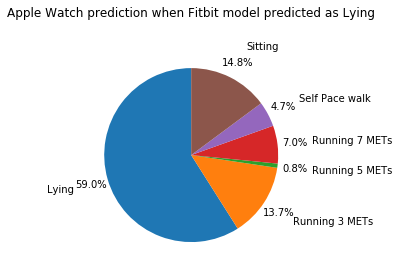

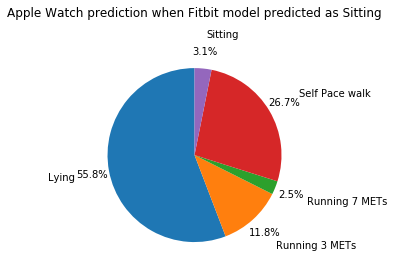

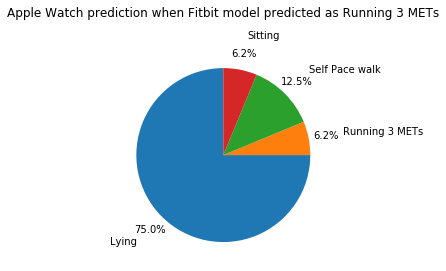

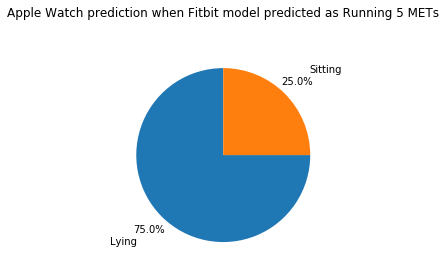

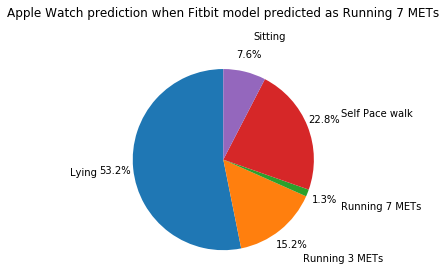

In [89]:
# your code goes here
loaded_model_fb = pickle.load(open(model_fitbit, 'rb'))
loaded_model_aw = pickle.load(open(model_aw, 'rb'))
pred_fitbit = []
pred_aw = []
records = []

#for each of the feature except gender, a random integer is generated in the range of 25% and 75% of the values, in case
#there are outliers
for i in range (1000):
    age = random.randint(20,80)
    female = random.randint(0,1)
    if female == 0:
        male = 1
    else:
        male = 0
    height = random.randint(160,180)
    weight = random.randint(60,77)
    heart_rate = random.randint(76, 96)
    resting_heart = random.randint(64,74)
    karvonen = random.randint(139,148)
    karvonen_minus_hr = karvonen-heart_rate
    calories = random.randint(0,21)
    steps = random.randint(1,106)
    distance = random.randint(0,16)
    records.append([age, female, male, height, weight, heart_rate, resting_heart, karvonen, karvonen_minus_hr, calories, steps, distance])

for i in records:
        pred_fitbit.append(loaded_model_fb.predict([i])[0])
        pred_aw.append(loaded_model_aw.predict([i])[0])

#make a dataframe to visualize the predicted results
final_pred = {'Apple Watch prediction' :pred_aw, 'Fitbit prediction': pred_fitbit}
final_pred_pd = pd.DataFrame(final_pred, columns = ['Apple Watch prediction','Fitbit prediction'])

#make a list of all activities
activity = ['Lying','Sitting','Self Pace Walk','Running 3 METs','Running 5 METs','Running 7 METs']

#see the percentages of the predictions that match 
match = final_pred_pd.mask(final_pred_pd['Fitbit prediction']!=final_pred_pd['Apple Watch prediction'])
print(match['Fitbit prediction'].count()*100/final_pred_pd['Fitbit prediction'].count(), 'percentage of the predictions matches')

#for every activity that fitbit model predicted, see what is the prediction using apple watch model
for i in range (len(activity)):
    mask = final_pred_pd.mask(final_pred_pd['Fitbit prediction']!=activity[i])
    groups = mask.groupby('Apple Watch prediction')
    if mask['Apple Watch prediction'].count()!=0:
        print('Fitbit model predicted ' + str(mask['Apple Watch prediction'].count()) + ' people were ' + activity[i])
        plt.figure(i)
        pie_chart = groups.size().plot(kind='pie', autopct='%1.1f%%', pctdistance=1.2, labeldistance=1.4, startangle=90)
        pie_chart.set_ylabel('')
        pie_chart.set_xlabel('')
        pie_chart.set_title('Apple Watch prediction when Fitbit model predicted as '+ activity[i],pad=30)
plt.tight_layout()
plt.show()

#### Analysis on the prediction results
When predicting an activity is lying, both models agreed on the results for more than 50% of times. When predicting every other activity, the model results are not the same for most of the time. Only 17.4 percentage of overall activities predicted is agreed by both models. When Fitbit model predicts an activity, Apple Watch model usually predicts an activity that consumes fewer calories.

## 3. Summary
Here is where we analyze why the model was selected, how the model classified the data, and what does this mean for future predictions

The modes were selected because they were the most accurate ones for each device according to our analysis. The difference between accuracy of two devices is large. Data from fitbit can have an accuracy as high as 76 percent, but data from apple watch is only accurate for at most 35 percent of times. 

For both devices, the decision tree is the best model based on generalization accuracy. In our ensemble analysis, Stacking is a great method for both devices. 

For apple watch data, our model isn't promsing predicting the activities. If one would use it, Stacking can get it right for 35 percent of times. For Fitbit data, multiple models can predict it right for over 75 percent of times. The best model according to analysis is bagging of decision trees. 

Daniel Fuller on the Harvard website where we got our data from said he got an accuracy of 82.6% for Apple Watch data and 89.3% for Fitbit data. In comparison, we got an accuracy of 35.4% for Apple Watch data and 75.8% for Fitbit data. There is a difference because we did not use all the columns provided and there might have been data leakage prior to our data cleaning since there were many normalized columns in the dataset. 